In [8]:
import music21 as m21
import pandas as pd
from abc_utils import *
from matplotlib import pyplot as plt
import numpy as np
from hmmlearn import hmm
from mpl_toolkits.axes_grid1 import make_axes_locatable         # help from Stack Overflow here

RANDOM_STATE = 42
plt.rcParams["figure.dpi"] = 500

In [9]:
#  load in the dataset
# train, test = abc.load_harmonization_train_test()
train_set, train_lengths, _, val_set, val_lengths, _ = load_datasets()

In [10]:
train_set.head()

,measure,beat,chord,melody,first_key_in_song
0,0.0,1.0,1,80,G major
1,0.0,2.5,1,78,G major
2,0.0,3.0,1,77,G major
3,0.0,3.5,1,75,G major
4,1.0,1.0,22,77,G major


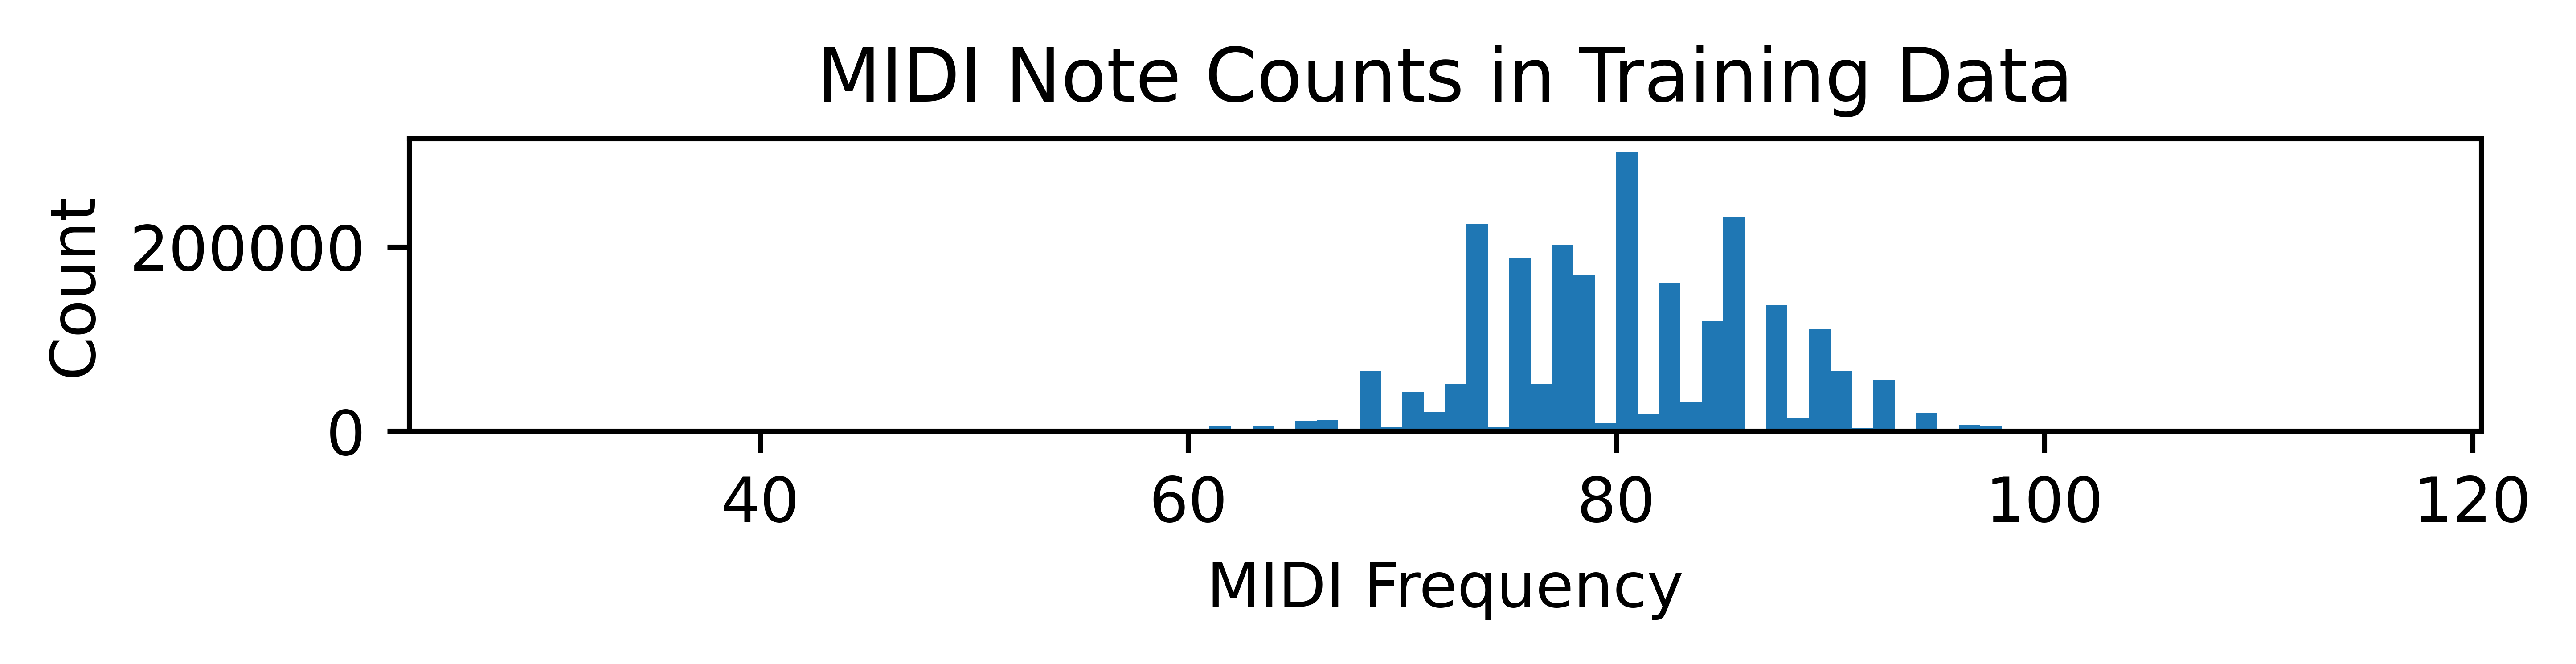

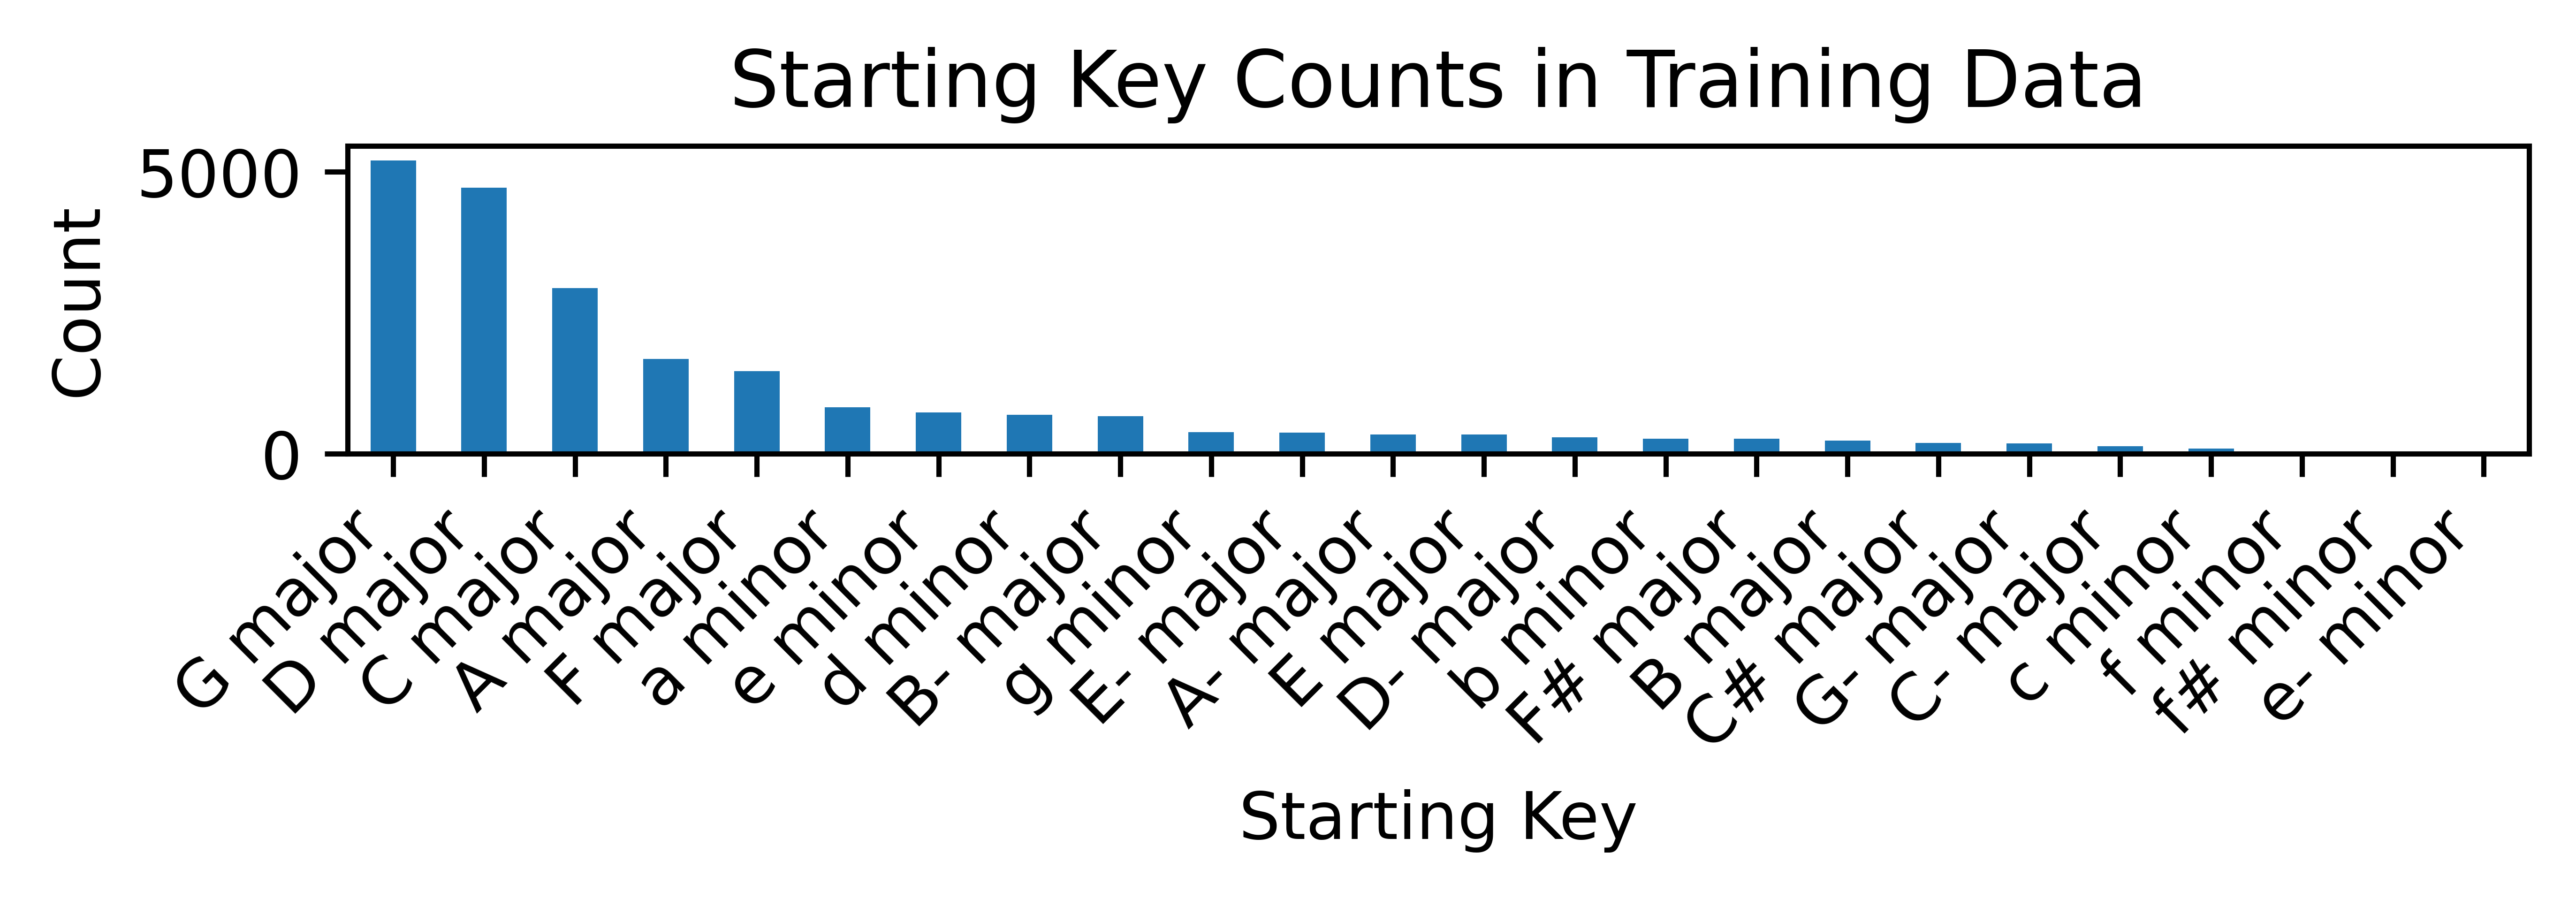

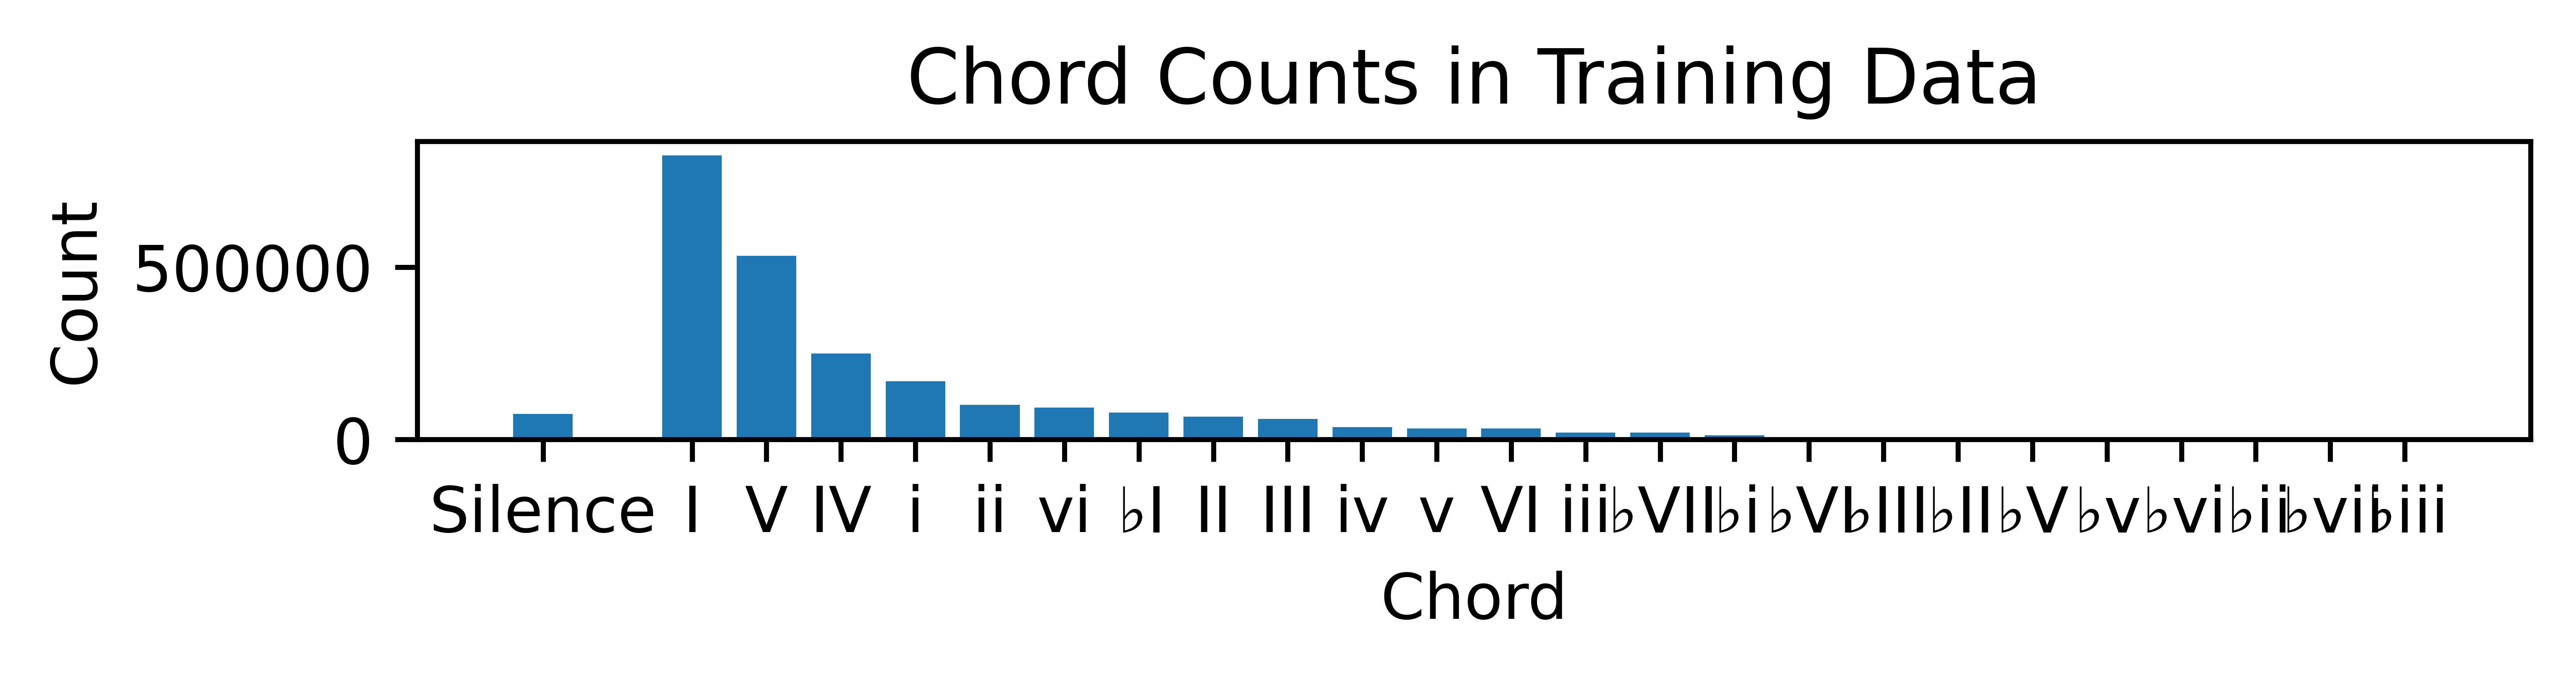

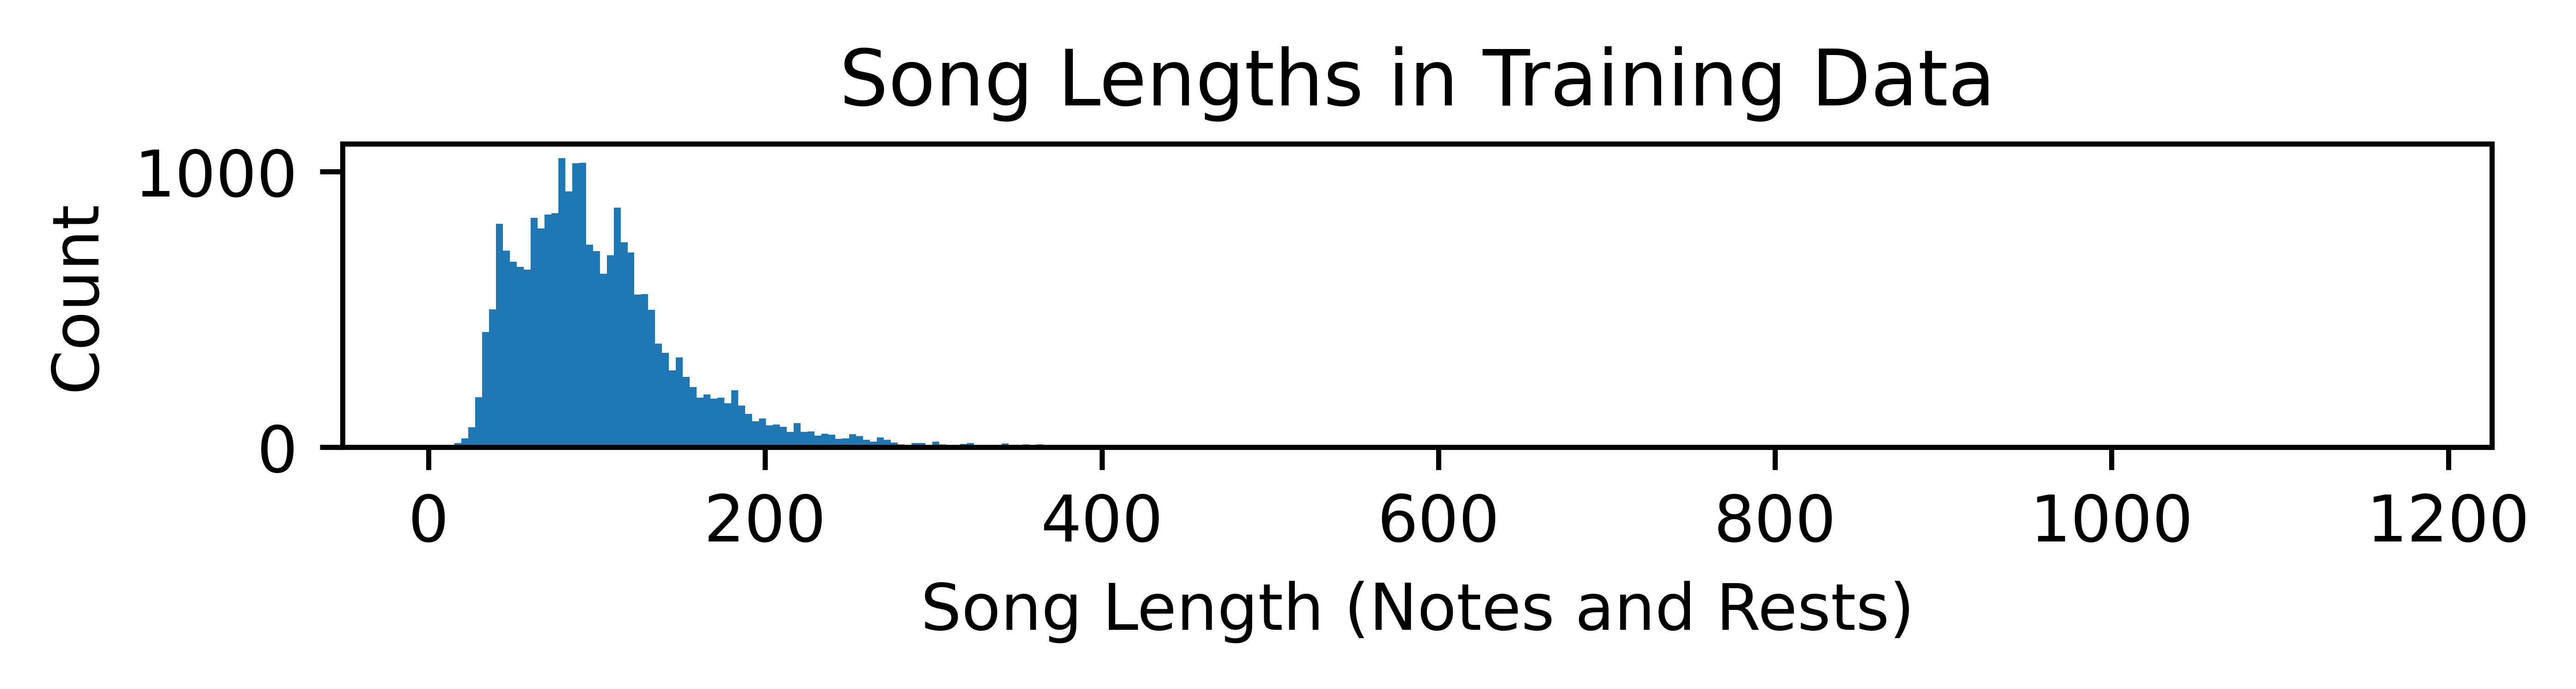

Number of Rests: 57791
Lowest Note MIDI Value: 28
Highest Note MIDI Value: 116


In [11]:
# plot the counts of the MIDI frequencies
# get all of the notes (count the rests and remove them)
all_notes = train_set['melody'].values
num_rests = np.sum(all_notes == 0)
all_notes = all_notes[all_notes != 0]

# get the high and low values and set the bins
low = np.min(all_notes)
high = np.max(all_notes)
bins = np.linspace(low, high, high - low + 1)

# plot
plt.subplot(411)
plt.hist(all_notes, bins=bins)
plt.title("MIDI Note Counts in Training Data")
plt.xlabel("MIDI Frequency")
plt.ylabel("Count")
plt.show()

# create a bar graph of the starting keys
all_keys = train_set['first_key_in_song']
indices = np.cumsum(train_lengths).values.flatten() - 1
final_keys = all_keys.iloc[indices]

# slice out indices where index is not major or minor
vals = final_keys.value_counts()
mask = [True if (("minor" in s) or ('major' in s)) else False for s in vals.index]
trunc_keys = vals[mask]

plt.subplot(412)
trunc_keys.plot.bar()
plt.xticks(rotation=45, ha="right")
plt.title("Starting Key Counts in Training Data")
plt.xlabel("Starting Key")
plt.ylabel("Count")
plt.show()

# create a histogram of the chords 
plt.subplot(413)
all_chords = train_set['chord'].values
all_chords = all_chords[all_chords != 0]
chord_list, counts = np.unique(all_chords, return_counts=True)
labels = [CHORD_INT_MAP[c] for c in chord_list]

# run through and set the flat symbols to look better
for i, l in enumerate(labels):
    if 'b' in l:
        labels[i] = r"$\flat$" + l[1:]
labels[0] = "Silence"
labels = np.array(labels)

# sort by frequency 
sort_inds = np.argsort(counts[1:])[::-1]
new_labels = labels[1:][sort_inds]
new_labels = np.insert(new_labels, 0, labels[0])

plt.bar(chord_list, np.insert(counts[1:][sort_inds], 0, counts[0]))
plt.xticks(chord_list, labels=new_labels)
plt.title("Chord Counts in Training Data")
plt.xlabel("Chord")
plt.ylabel("Count")
plt.show()

# plot the song lengths (number of notes and rests in the song)
plt.subplot(414)
plt.hist(train_lengths.values.flatten(), bins='auto')
plt.title("Song Lengths in Training Data")
plt.xlabel("Song Length (Notes and Rests)")
plt.ylabel("Count")
plt.show()

# print descriptive statistics
print("Number of Rests:", num_rests)
print("Lowest Note MIDI Value:", low)
print("Highest Note MIDI Value:", high)

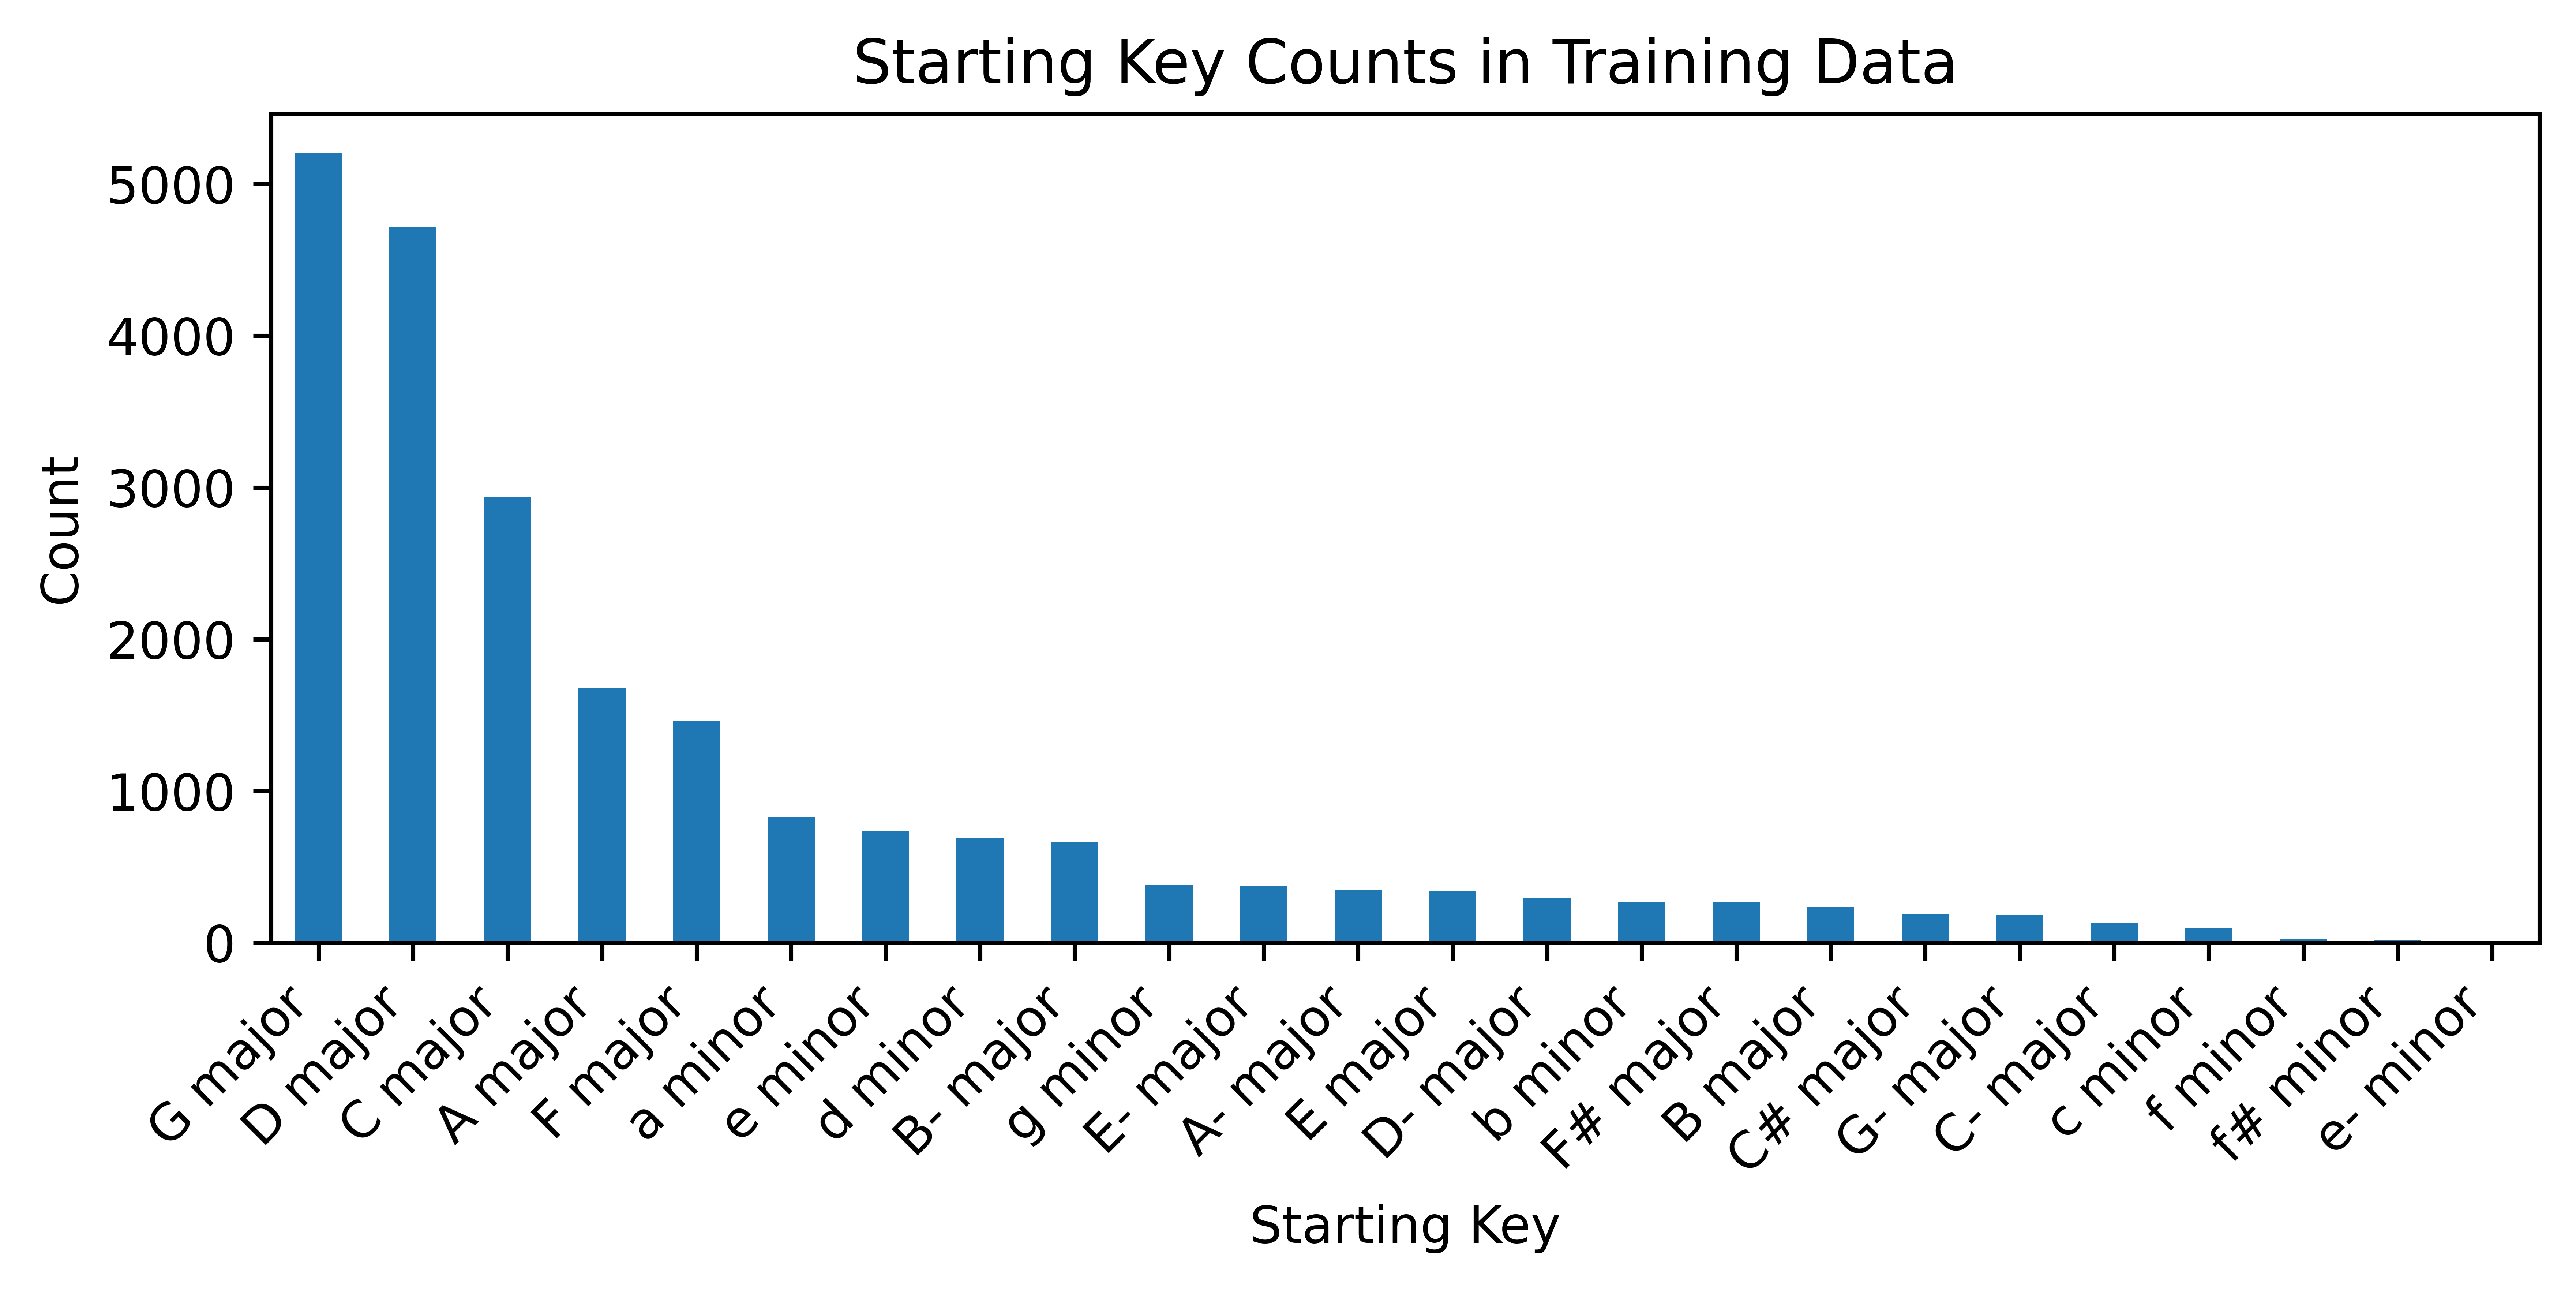

In [12]:
# create a bar graph of the starting keys
all_keys = train_set['first_key_in_song']
indices = np.cumsum(train_lengths).values.flatten() - 1
final_keys = all_keys.iloc[indices]

# slice out indices where index is not major or minor
vals = final_keys.value_counts()
mask = [True if (("minor" in s) or ('major' in s)) else False for s in vals.index]
trunc_keys = vals[mask]

plt.figure(figsize=(8,3))
trunc_keys.plot.bar()
plt.xticks(rotation=45, ha="right")
plt.title("Starting Key Counts in Training Data")
plt.xlabel("Starting Key")
plt.ylabel("Count")
plt.show()

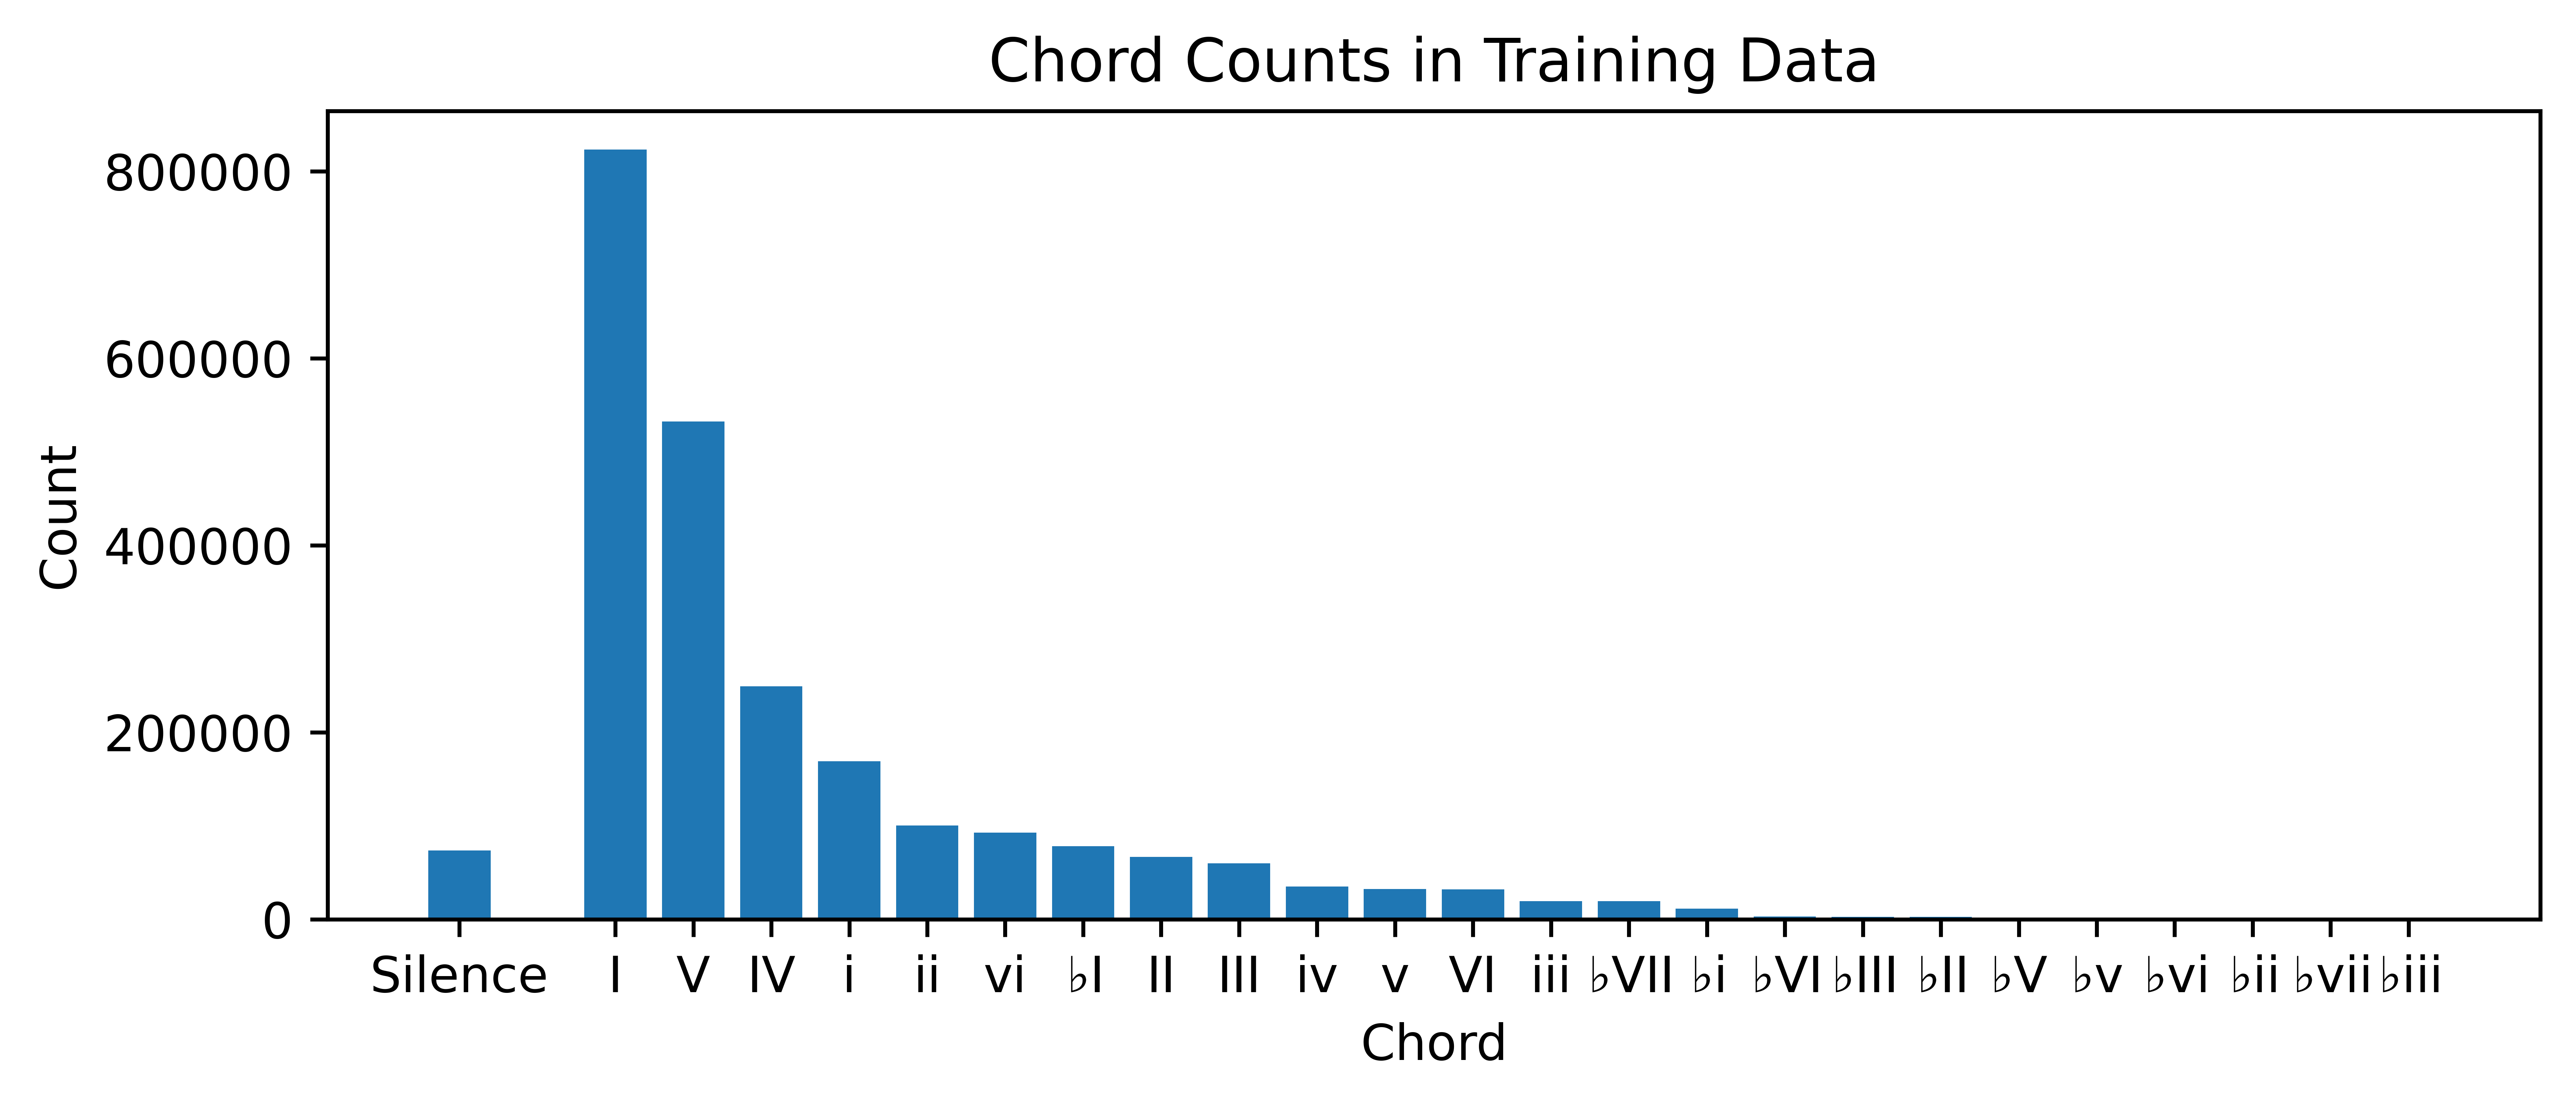

In [13]:
# create a histogram of the chords 
plt.figure(figsize=(8,3))
all_chords = train_set['chord'].values
all_chords = all_chords[all_chords != 0]
chord_list, counts = np.unique(all_chords, return_counts=True)
labels = [CHORD_INT_MAP[c] for c in chord_list]

# run through and set the flat symbols to look better
for i, l in enumerate(labels):
    if 'b' in l:
        labels[i] = r"$\flat$" + l[1:]
labels[0] = "Silence"
labels = np.array(labels)

# sort by frequency 
sort_inds = np.argsort(counts[1:])[::-1]
new_labels = labels[1:][sort_inds]
new_labels = np.insert(new_labels, 0, labels[0])

plt.bar(chord_list, np.insert(counts[1:][sort_inds], 0, counts[0]))
plt.xticks(chord_list, labels=new_labels)
plt.title("Chord Counts in Training Data")
plt.xlabel("Chord")
plt.ylabel("Count")
plt.show()


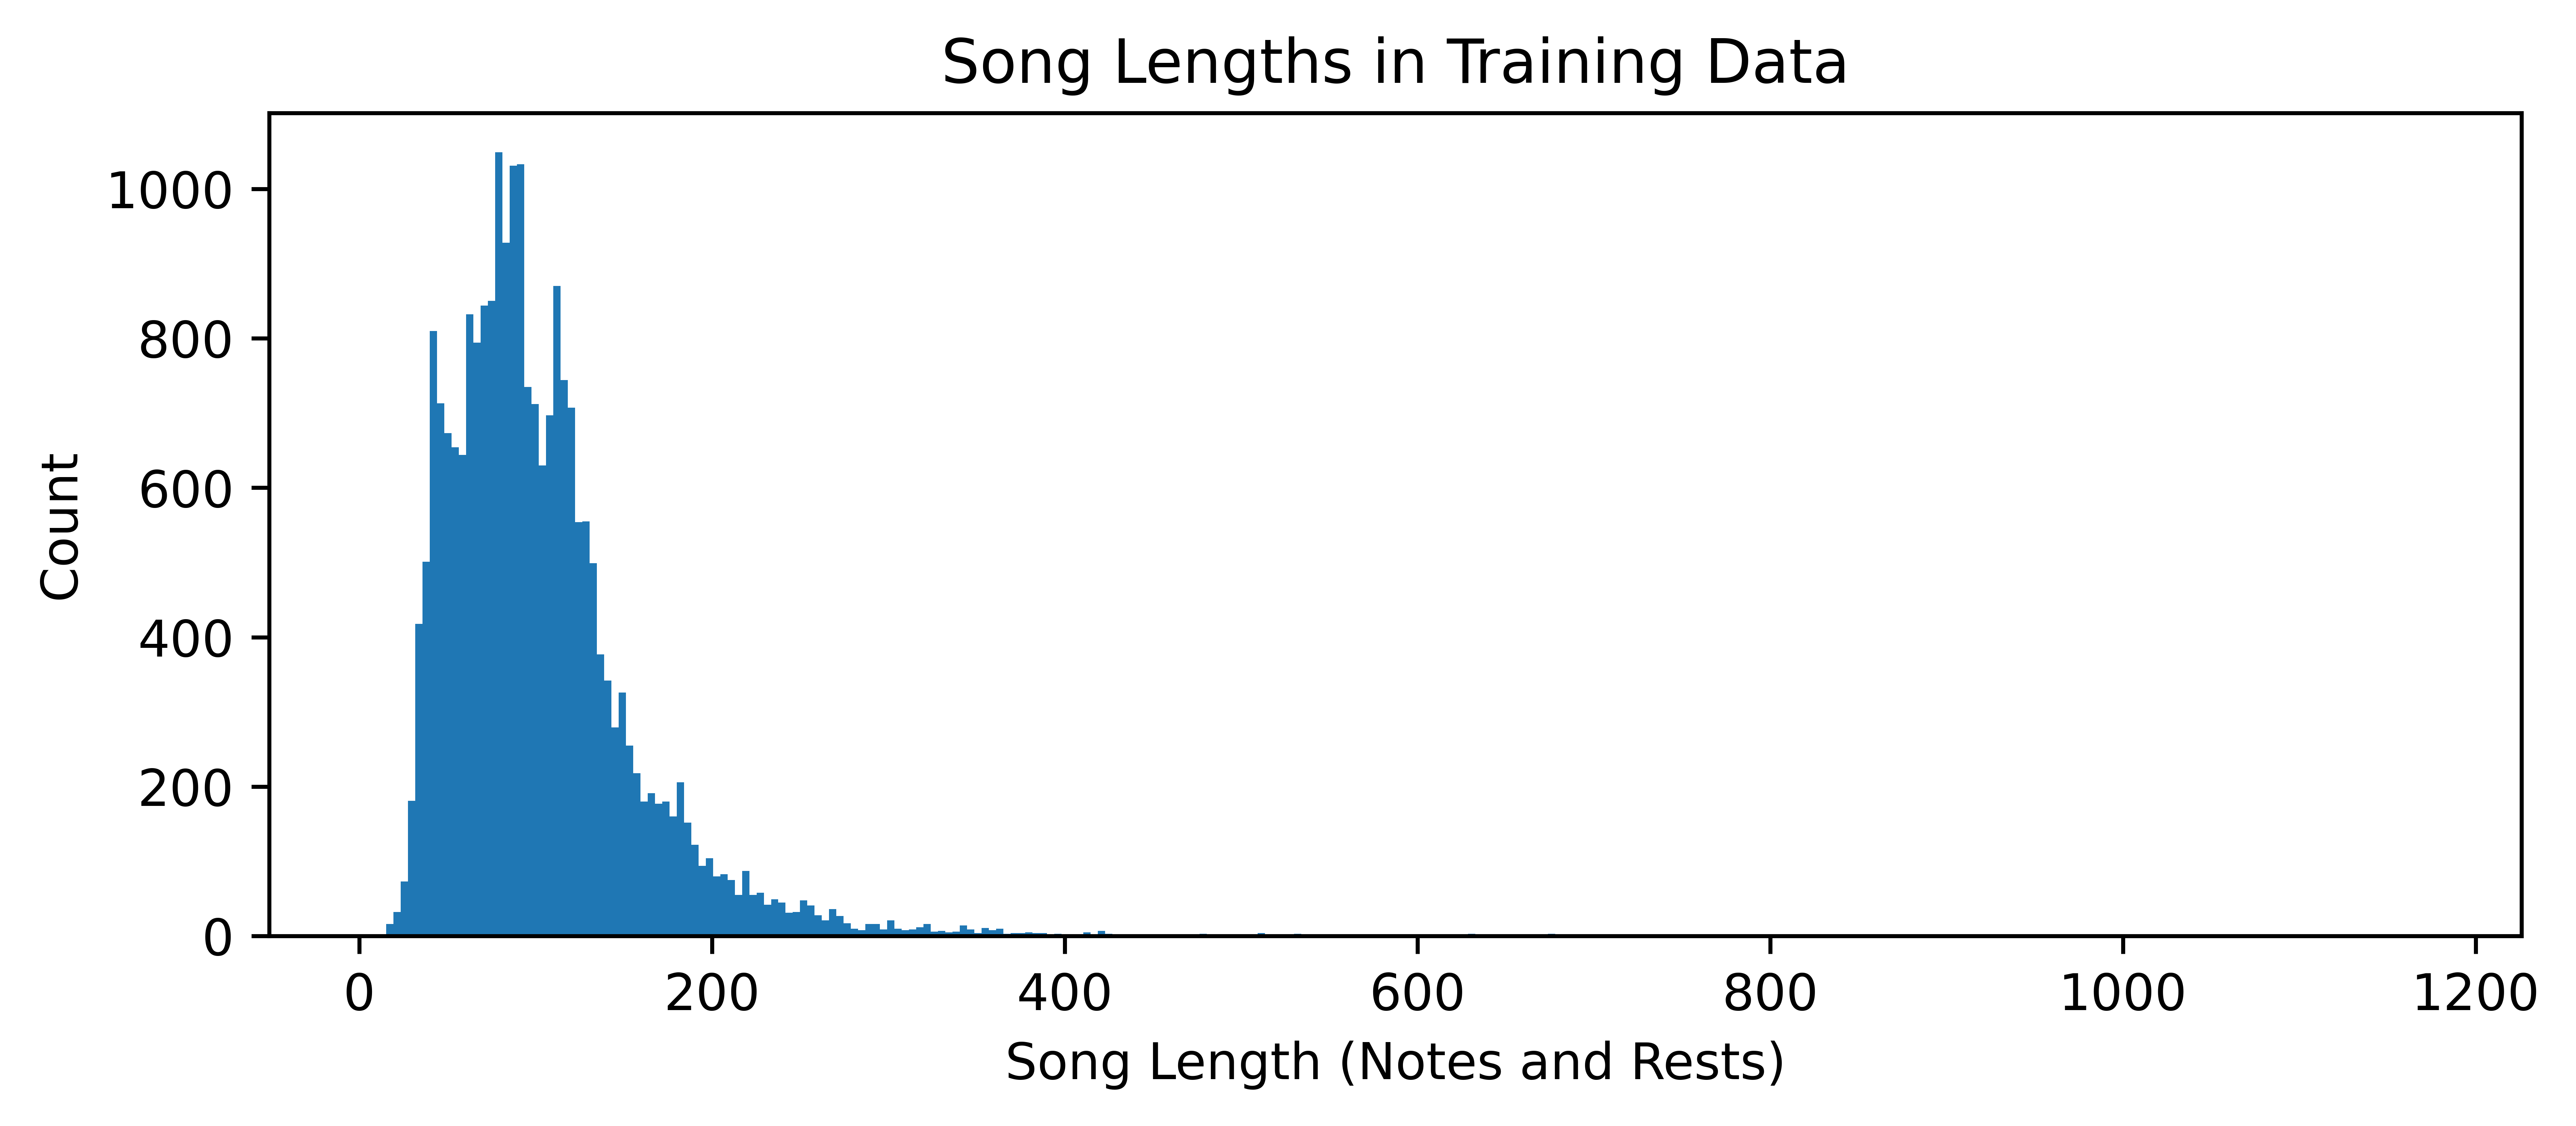

In [14]:
# plot the song lengths (number of notes and rests in the song)
plt.figure(figsize=(8,3))
plt.hist(train_lengths.values.flatten(), bins='auto')
plt.title("Song Lengths in Training Data")
plt.xlabel("Song Length (Notes and Rests)")
plt.ylabel("Count")
plt.show()

In [15]:
def load_song_subset(train_set, train_lengths, indices):
    """
    Create a subset of the train"""
    end_positions = np.cumsum(train_lengths)
    positions = np.insert(end_positions, 0, np.array([0]))
    songs = []
    for i in indices:
        song = train_set.iloc[positions[i] : positions[i+1]]
        songs.append(song)

    # return songs and lengths
    return pd.concat(songs), train_lengths.iloc[indices]

In [16]:
def fit_model(train_set: pd.DataFrame, train_lengths: pd.Series, num_chords: int=1, num_notes: int=0, subset: bool=False, indices=None, lam: int=None):
    """ 
    Takes in the train set and parameters for the state space and returns the trained model, along with all of the dictionaries needed to decode the model as a tuple.

    To train on a smaller subset of the full train set, use the subset argument and pass in the indices needed. Uses the load_song_subset function.
    """
    # check if we want to do a subset of the full train set; if so, perform it
    if subset:
        # check that indices are specified; raise and error if not
        if indices is None:
            raise ValueError("Indices must be specified if subset=True")
        train_set, _ = load_song_subset(train_set, train_lengths, indices)

    # obtain the states and observations from the songs
    true_states, true_observations = dataframe_to_states(train_set, num_chords, num_notes)
    
    # create the transition matrices for the model
    transition_matrix, emission_probs, unique_states, unique_obs, states_to_index, observation_to_index = states_to_transition(true_states, true_observations, lam)

    # now initialize the model and set the matrices for it
    model = hmm.CategoricalHMM(n_components=transition_matrix.shape[0], init_params='')
    model.transmat_ = transition_matrix.T
    model.emissionprob_ = emission_probs.T

    # starting_state = np.zeros(unique_states.shape[1])
    # starting_state_index = states_to_index[tuple(starting_state)]

    # start_probs = np.zeros(transition_matrix.shape[0])
    # start_probs[starting_state_index] = 1
    
    model.startprob_ = np.ones(transition_matrix.shape[0]) / transition_matrix.shape[0]

    # return the model,  the dictionaries
    return model, (unique_states, unique_obs, states_to_index, observation_to_index)

In [17]:
# create the confusion matrices for the redacted and non-redacted versions

num_chords = 1
num_notes = 0

fig, axes = plt.subplots(1, 4, figsize=(16, 5))
# fig, axes = plt.subplots(nrows=1, ncols=4)
# for ax in axes.flat:
#     im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1)

# fig.colorbar(im, ax=axes.ravel().tolist())

# plt.show()
for i, lam in enumerate([None, 4, 3, 2]):
    # train the model
    model, all_dicts = fit_model(train_set, train_lengths, num_chords, num_notes, lam=lam)

    # get the transition matrix and plot it
    ax = axes[i]
    im = ax.imshow(model.transmat_, vmin=0, vmax=1)
    ax.set_title(r"$\lambda$ = "+str(lam))
    ax.set_xticks([])
    ax.set_yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

fig.suptitle(r"Transition Matrices with Redact Parameter $\lambda$", fontsize=24)
plt.tight_layout()
plt.show()


Processing states: 100%|██████████| 2414976/2414976 [01:22<00:00, 29153.28it/s]
